<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Juypter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Numerical methods:  9. Initial-value problems
## Runge-Kutta-Fehlberg method with adaptive step size
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

In this notebook, we discuss solution strategies for differential eqautions with boundary conditions
defined along **one side**, the group of `initial-value problems`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# load own library
import numerics.change_fonts
numerics.change_fonts.change_fontsize()

We first define a differential equation of first order with an initial value:
$$
\begin{array}{rcl}
{{dy}\over{dt}} &=& y - t^2 +1, \quad 0 \le t \le 2 \\
y(t=0) &=& 0.5
\end{array}
$$

We define the right-hand side of the differential equation as function:

In [2]:
def rhs(t,y):
    '''
    #----------------------------------------------------------------------
    # right-hand side function rhs(x)
    #----------------------------------------------------------------------
    '''
    y = y - t**2 + 1
    return y

A solution of the above differential equation is:
$$
y(t) = (t+1)^2 - 0.5 e^{t}
$$
which we use as analytical solution for comparison ...

In [3]:
def fexact(t):
    # analytical solution
    y = (t + 1)**2 - 0.5*np.exp(t)
    return y

## Runge-Kutta-Fehlberg method with adaptive stepsize

One of the most widely-used methods to solve such a differential equation is the **Runge-Kutta method**:
$$
\begin{array}{rcl}
w_0     & = & \alpha \\
 k_1 & = & h f(t_i,w_i) \\
 k_2 & = & h f(t_i+{h \over 4},w_i+{1 \over 4}k_1) \\
 k_3 & = & h f(t_i+{3h \over 8},w_i+{3 \over 32}k_1+{9 \over 32}k_2) \\
 k_4 & = & h f(t_i+{12h \over 13},w_i+{1932 \over 2197}k_1-{7200 \over 2197}k_2
                                                          +{7296 \over 2197}k_3) \\
 k_5 & = & h f(t_i+h,w_i+{439 \over 216}k_1-8k_2+{3680 \over 513}k_3
                                                -{845 \over 4104}k_4) \\
 k_6 & = & h f(t_i+{h \over 2},w_i-{8 \over 27}k_1-2k_2-{3544 \over 2565}k_3
                                                +{1859 \over 4104}k_4
                                                -{11 \over 55}k_5) \\
w_{i+1} & = &
 w_i + {25 \over 216} k_1 
     + {1408 \over 2565} k_3 
     + {2197 \over 4104} k_4 
     - {1 \over 5} k_5 + O(h^{5}) \\
 \tilde{w}_{i+1} 
 & = &
 \tilde{w}_i + {16 \over 135} k_1 
             + {6656 \over 12825} k_3 
             + {28561 \over 56430} k_4 
             - {9 \over 50} k_5
             + {2 \over 55} k_6 + O(h^{6})
\end{array}
$$
Here, $w_0$ is the initial value, $w_i$ the iterative solution at point $t_i$, 
with $t$ the independent variable.

The **local error** between the two solutions is given as:
$
\Delta = |\tilde{w}_{i+1} - w_{i+1}|
$

We compare two step sizes, $h_0$ and $h_1$, with $h_0$ for the desired tolerance~$\epsilon$:
$$
h_0 = h_1 \left| \frac{\epsilon}{\Delta} \right|^{{{1}\over{5}}}
$$

We reformulate the solution strategy as function:

In [4]:
def ivp_rk4_fehlberg(rhs,a,b,alpha,hmin,hmax,tol):
    """
    !-----------------------------------------------------------------------
    ! subroutine performs Runge-Kutta Fehlberg integration for ordinary DGL
    ! with adaptable stepsize
    ! y' = f(t,y), y(0)=y_1, t in [a,b]
    ! Input:
    ! rhs   - right hand side of differential equation
    ! a,b   - start, end point of interval
    ! hmin  - minimum step size
    ! hmax  - maximum step size
    ! y     - approximate solution w_i
    ! tol   - accuracy
    ! Output:
    ! ynew  - new approximate solution w_(i+1)
    ! (c) Georg Kaufmann
    !-----------------------------------------------------------------------
    """
    h = hmax
    i = 0
    t = []; y = []
    t.append(a)
    y.append(alpha)
    while (t[i] < b):
        # coefficients for both Runge-Kutta methods
        k1 = h*rhs(t[i],y[i])
        k2 = h*rhs(t[i]+h/4,y[i]+k1/4)
        k3 = h*rhs(t[i]+3*h/8,y[i]+(3*k1+9*k2)/32)
        k4 = h*rhs(t[i]+12*h/13,y[i]+(1932*k1-7200*k2+7296*k3)/2197)
        k5 = h*rhs(t[i]+h,y[i]+439*k1/216-8*k2+3680*k3/513-845*k4/4104)
        k6 = h*rhs(t[i]+h/2,y[i]-8*k1/27+2*k2-3544*k3/2565+1859*k4/4104-11*k5/40)
        # difference |w_i - tilde(w_i)| / h
        r  = np.abs(k1/360-128*k3/4275-2197*k4/75240+k5/50+2*k6/55)/h
        # check step size, avoid underflow
        if (r > 1.0e-20):
            delta = 0.84*(tol/r)**0.25
        else:
            delta = 10.
        # if tolerance is achieved, proceed
        if (r <= tol):
            i = i + 1
            t.append(t[i-1]+h)
            y.append(y[i-1] + 25*k1/216+1408*k3/2565+2197*k4/4104-k5/5)
        # estimate new step size
        if (delta <= 0.1):
            h = 0.1*h
        elif (delta >= 4.):
            h = 4.*h
        else:
            h = delta*h
        # check if stepsize will become too large or too small
        if (h > hmax):
            h = hmax
        if (h < hmin):
            print ('odei_rk_fehlberg: h < hmin')
        # check that step will not exceed upper limit
        if (t[i]+h > b):
            h = b-t[i]
    return t,y

In [5]:
def ivp_rk4(rhs,t,y,h):
    '''
    # subroutine performs Runge-Kutta fourth-order integration for ordinary DGL
    # y' = f(t,y), y(0)=y_1, t in [a,b]
    # Input:
    # rhs   - right hand side of differential equation
    # t     - integration variable t_i
    # y     - approximate solution w_i
    # h     - step size
    # Output:
    # ynew  - new approximate solution w_(i+1)
    # (c) Georg Kaufmann
    #----------------------------------------------------------------------
    '''
    k1   = h*rhs(t,y);
    k2   = h*rhs(t+h/2,y+k1/2);
    k3   = h*rhs(t+h/2,y+k2/2);
    k4   = h*rhs(t+h,y+k3);
    ynew = y + 1 / 6 * (k1+2*k2+2*k3+k4);
    return ynew

In [6]:
def ivp_eulermod(rhs,t,y,h):
    '''
    #----------------------------------------------------------------------
    # subroutine performs modified Euler integration for ordinary DGL
    # y' = f(t,y), y(0)=y_1, t in [a,b]
    # Input:
    # rhs   - right hand side of differential equation
    # t     - integration variable t_i
    # y     - approximate solution w_i
    # h     - step size
    # Output:
    # ynew  - new approximate solution w_(i+1)
    # (c) Georg Kaufmann
    #----------------------------------------------------------------------
    '''
    k1   = rhs(t,y)
    k2   = rhs(t+h,y+h*k1)
    ynew = y + h / 2. * (k1+k2)
    return ynew

In [7]:
def ivp_euler(rhs,t,y,h):
    '''
    #----------------------------------------------------------------------
    # subroutine performs simple Euler integration for ordinary DGL
    # y' = f(t,y), y(0)=y_1, t in [a,b]
    # Input:
    # rhs   - right hand side of differential equation
    # t     - integration variable t_i
    # y     - approximate solution w_i
    # h     - step size
    # Output:
    # ynew  - new approximate solution w_(i+1)
    # (c) Georg Kaufmann
    #----------------------------------------------------------------------
    '''
    k1 = rhs(t,y)
    ynew = y + h * k1
    return ynew

Set the initial condition and the integration parameters:

In [8]:
a     = 0.
b     = 5.
alpha = 0.5
n = 21
h = (b-a) / float(n-1)
print ("%3s %5.2f %3s %5.2f %7s %5.2f %3s %4i %3s %5.2f" % ('a:',a,'b:',b,'alpha:',alpha,'n:',n,'h:',h))

 a:  0.00  b:  5.00  alpha:  0.50  n:   21  h:  0.25


In [9]:
tfehlberg,yfehlberg=ivp_rk4_fehlberg(rhs,a,b,alpha,0.1*h,10.*h,0.01)

Then solve the differential equation:

In [10]:
t = np.array([]); y1 = np.array([]); y2 = np.array([]); y3 = np.array([]); yexact = np.array([])
# initial values
t=np.append(t,a)
y1=np.append(y1,alpha)
y2=np.append(y2,alpha)
y3=np.append(y3,alpha)
yexact=np.append(yexact,alpha)
print ("%4i %10.4f %10.4f %10.2f %10.4f %10.4f %10.4f" % (0,h,t[0],y1[0],y2[0],y3[0],yexact[0]))
# run over interal
for i in np.arange(1,n):
    t=np.append(t,t[i-1]+h)
    ynew = ivp_euler(rhs,t[i-1],y1[i-1],h)
    y1=np.append(y1,ivp_euler(rhs,t[i-1],y1[i-1],h))
    y2=np.append(y2,ivp_eulermod(rhs,t[i-1],y2[i-1],h))
    y3=np.append(y3,ivp_rk4(rhs,t[i-1],y3[i-1],h))
    yexact=np.append(yexact,fexact(t[i]))
    print ("%4i %10.4f %10.4f %10.2f %10.4f %10.4f %10.4f" % (i,h,t[i],y1[i],y2[i],y3[i],yexact[i]))

   0     0.2500     0.0000       0.50     0.5000     0.5000     0.5000
   1     0.2500     0.2500       0.88     0.9141     0.9205     0.9205
   2     0.2500     0.5000       1.33     1.4114     1.4256     1.4256
   3     0.2500     0.7500       1.85     1.9802     2.0039     2.0040
   4     0.2500     1.0000       2.42     2.6055     2.6408     2.6409
   5     0.2500     1.2500       3.02     3.2680     3.3172     3.3173
   6     0.2500     1.5000       3.64     3.9430     4.0090     4.0092
   7     0.2500     1.7500       4.24     4.5988     4.6850     4.6852
   8     0.2500     2.0000       4.78     5.1949     5.3052     5.3055
   9     0.2500     2.2500       5.22     5.6794     5.8183     5.8186
  10     0.2500     2.5000       5.52     5.9858     6.1584     6.1588
  11     0.2500     2.7500       5.58     6.0286     6.2407     6.2412
  12     0.2500     3.0000       5.34     5.6988     5.9567     5.9572
  13     0.2500     3.2500       4.67     4.8563     5.1667     5.1673
  14  

Finally, we compare the numerical solution with the analytical solution:

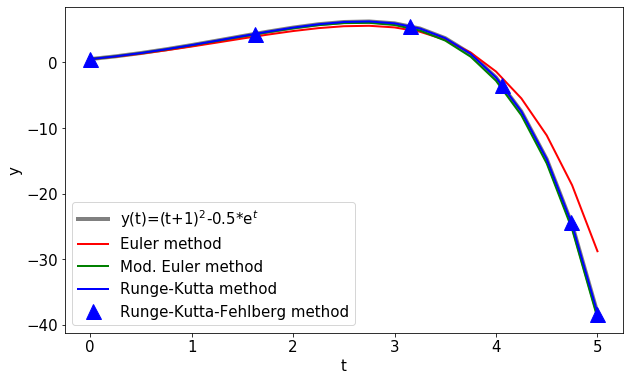

In [11]:
plt.figure(figsize=(10,6))
plt.xlabel('t')
plt.ylabel('y')
plt.plot(t,yexact,linewidth=4,color='gray',label='y(t)=(t+1)$^2$-0.5*e$^t$')
plt.plot(t,y1,linewidth=2,color='red',label='Euler method')
plt.plot(t,y2,linewidth=2,color='green',label='Mod. Euler method')
plt.plot(t,y3,linewidth=2,color='blue',label='Runge-Kutta method')
plt.plot(tfehlberg,yfehlberg,linewidth=0,marker='^',markersize=15,color='blue',label='Runge-Kutta-Fehlberg method')
plt.legend()

----
[next>](Numerics_lab09_rungekutta_system.ipynb)